In [107]:
import csv
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import sklearn
from torch.utils.data import Dataset
import os

In [166]:
names = ["cho2","jeon2","kim2"]
# names = ["cho2"]
file_names = ["./class1.npy","./class2.npy","./class3.npy","./class4.npy"]

In [207]:
data = []
data_pth = "./customdata"
for name in names:
    name_pth = os.path.join(data_pth, name)
    for file_name in file_names:
        file_pth = os.path.join(name_pth,file_name)
        data.append(np.load(file_pth))

data = np.concatenate(data,axis=0)

In [208]:
data.shape

(6000, 64)

In [209]:
data[:,0]-1

array([0., 0., 0., ..., 3., 3., 3.])

In [210]:
def to_onehot(labels,num_classes):
    out = np.zeros((labels.shape[0],num_classes))
    for i in range(labels.shape[0]):
        out[i][int(labels[i])]=1
    return out

In [211]:
class CustomDataset_np(Dataset):
    def __init__(self, np_array ,num_class):
        self.data = np_array
        self.labels = torch.tensor(to_onehot(self.data[:,0]-1,num_class),dtype=torch.float32)
        self.keypoints = torch.tensor(self.data[:,1:], dtype=torch.float32)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self,idx):
        keypoint = self.keypoints[idx]
        label = self.labels[idx]
        return keypoint, label

In [212]:
dataset = CustomDataset_np(data, num_class = 4)
train_set, test_set = torch.utils.data.random_split(dataset, [5500,500])

In [213]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 128, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 128, shuffle = True)

In [214]:
next(iter(train_loader))

[tensor([[-0.0000, -0.0000, -0.0000,  ..., -0.0133,  0.0243,  0.0083],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0495,  0.0160,  0.0025],
         [-0.0000, -0.0000, -0.0000,  ..., -0.0172,  0.0172,  0.0382],
         ...,
         [-0.0000, -0.0000, -0.0000,  ...,  0.0179,  0.0527,  0.0294],
         [-0.0000, -0.0000, -0.0000,  ..., -0.0116,  0.0266,  0.0080],
         [-0.0000, -0.0000, -0.0000,  ..., -0.0163,  0.0171,  0.0182]]),
 tensor([[0., 0., 1., 0.],
         [1., 0., 0., 0.],
         [0., 0., 0., 1.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 1., 0.],
         [1., 0., 0., 0.],
         [0., 0., 1., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [1., 0., 

In [215]:
class model(nn.Module):
    def __init__(self,num_class,dimension):
        super().__init__()
        self.linear1 = nn.Linear(21*dimension,2**(dimension+2)) 
        self.Dropout1 = nn.Dropout(p = 0.2)
        self.act1 = nn.ReLU()
        
        self.linear2 = nn.Linear(2**(dimension+2),2**(dimension+1))
        self.Dropout2 = nn.Dropout(p=0.2)
        self.act2 = nn.ReLU() 
        
        self.linear3 = nn.Linear(2**(dimension+1),num_class)
        self.act3 = nn.Sigmoid()
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.Dropout1(out)
        out = self.act1(out)
        out = self.linear2(out)
        out = self.Dropout2(out)
        out = self.act2(out)    
        out = self.linear3(out)
        out = self.act3(out)  
        return out

In [216]:
class model_2(nn.Module):
    def __init__(self,num_class,dimension):
        super().__init__()
        self.linear1 = nn.Linear(21*dimension,2**(dimension+3)) 
        self.Dropout1 = nn.Dropout(p = 0.2)
        self.act1 = nn.ReLU()
        
        self.linear2 = nn.Linear(2**(dimension+3),2**(dimension+2))
        self.Dropout2 = nn.Dropout(p=0.2)
        self.act2 = nn.ReLU() 
        
        self.linear3 = nn.Linear(2**(dimension+2),2**(dimension+1))
        self.Dropout3 = nn.Dropout(p=0.2)
        self.act3= nn.ReLU() 
        
        self.linear4 = nn.Linear(2**(dimension+1),num_class)
        self.act4 = nn.Sigmoid()
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.Dropout1(out)
        out = self.act1(out)
        out = self.linear2(out)
        out = self.Dropout2(out)
        out = self.act2(out)   
        
        out = self.linear3(out)
        out = self.Dropout3(out)
        out = self.act3(out)  
        
        out = self.linear4(out)
        out = self.act4(out)  
        return out

In [217]:
model = model_2(num_class = 4, dimension=3)

import torch.optim as optim
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters() , lr = 0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 500,gamma=0.1)
num_epochs = 5000
loss_his = []
test_accuracy_his = []
test_loss_his = []

In [218]:
for epoch in range(num_epochs):
    running_loss = 0.0
    print("epoch : {}".format(epoch))
    for i,data in enumerate(train_loader):
        keypoint, labels = data
        optimizer.zero_grad()
        out = model(keypoint)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        loss_his.append(loss.item())
        running_loss += loss.item()
    print("loss : {}".format(running_loss/2000))
    if epoch%100 == 99:
        pred_test = model(test_set[:][0])
        correct = 0
        for i in range(len(test_set)):
            if pred_test[i].argmax() == test_set[i][1].argmax() :
                correct = correct+1
        print("test accuracy = ", correct/len(test_set))
        test_accuracy_his.append(correct/len(test_set))
    scheduler.step()
#         test_loss_his.append(criterion(pred_test, test_set[i][1]))
        

    
    

epoch : 0
loss : 0.025841478526592254
epoch : 1
loss : 0.02365873920917511
epoch : 2
loss : 0.0227425836622715
epoch : 3
loss : 0.020999532073736192
epoch : 4
loss : 0.020359825313091277
epoch : 5
loss : 0.02017986187338829
epoch : 6
loss : 0.02012137195467949
epoch : 7
loss : 0.020071204006671905
epoch : 8
loss : 0.020062415063381196
epoch : 9
loss : 0.020040617197752
epoch : 10
loss : 0.02004632115364075
epoch : 11
loss : 0.02004181945323944
epoch : 12
loss : 0.020009951055049897
epoch : 13
loss : 0.020012893199920653
epoch : 14
loss : 0.020033317148685455
epoch : 15
loss : 0.020036190390586853
epoch : 16
loss : 0.020011236131191254
epoch : 17
loss : 0.020010184019804002
epoch : 18
loss : 0.019996546775102614
epoch : 19
loss : 0.018609739363193514
epoch : 20
loss : 0.017541762262582777
epoch : 21
loss : 0.017489242643117905
epoch : 22
loss : 0.017509134650230407
epoch : 23
loss : 0.017518792569637297
epoch : 24
loss : 0.017520867109298705
epoch : 25
loss : 0.01749939924478531
epoch :

loss : 0.016119475424289702
epoch : 210
loss : 0.016127744644880294
epoch : 211
loss : 0.016126222848892213
epoch : 212
loss : 0.016125762671232224
epoch : 213
loss : 0.016141136139631272
epoch : 214
loss : 0.016134916305541994
epoch : 215
loss : 0.01611670231819153
epoch : 216
loss : 0.01612920206785202
epoch : 217
loss : 0.01610923483967781
epoch : 218
loss : 0.016131455838680267
epoch : 219
loss : 0.01611448520421982
epoch : 220
loss : 0.016125696510076525
epoch : 221
loss : 0.016126909404993058
epoch : 222
loss : 0.01610499683022499
epoch : 223
loss : 0.016108520060777665
epoch : 224
loss : 0.016105292946100237
epoch : 225
loss : 0.016130921959877014
epoch : 226
loss : 0.016095127910375595
epoch : 227
loss : 0.016133203655481338
epoch : 228
loss : 0.016117754876613617
epoch : 229
loss : 0.016122345119714738
epoch : 230
loss : 0.016155624687671663
epoch : 231
loss : 0.016117473781108855
epoch : 232
loss : 0.01614271742105484
epoch : 233
loss : 0.016113861858844756
epoch : 234
loss :

KeyboardInterrupt: 

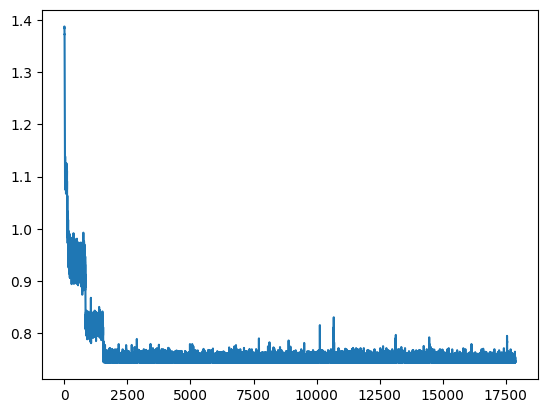

In [219]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(len(loss_his))],loss_his)

In [220]:
pred_test = model(test_set[:][0])
correct = 0
for i in range(len(test_set)):
    if pred_test[i].argmax() == test_set[i][1].argmax() :
        correct = correct+1
correct/len(test_set)

0.996

In [221]:
pred_train = model(train_set[:][0])
correct = 0
for i in range(len(train_set)):
    if pred_train[i].argmax() == train_set[i][1].argmax() :
        correct = correct+1
accuracy = correct / len(train_set)
accuracy

0.9972727272727273

In [222]:
torch.save(model.state_dict(),"./custom_model_4.pth")

In [224]:
train_set[3000]

(tensor([-0.0000, -0.0000, -0.0000, -0.0295,  0.0169,  0.0023, -0.0432,  0.0403,
         -0.0014, -0.0474,  0.0619, -0.0042, -0.0483,  0.0769, -0.0080, -0.0281,
          0.0657, -0.0188, -0.0314,  0.0882, -0.0206, -0.0324,  0.0994, -0.0183,
         -0.0324,  0.1098, -0.0159, -0.0145,  0.0685, -0.0188, -0.0183,  0.0929,
         -0.0216, -0.0202,  0.1055, -0.0183, -0.0225,  0.1154, -0.0150, -0.0019,
          0.0680, -0.0164, -0.0052,  0.0905, -0.0188, -0.0084,  0.1023, -0.0164,
         -0.0117,  0.1121, -0.0141,  0.0127,  0.0638, -0.0136,  0.0098,  0.0811,
         -0.0159,  0.0070,  0.0910, -0.0169,  0.0038,  0.0994, -0.0169]),
 tensor([0., 1., 0., 0.]))

In [ ]:
pred_test[4].argmax() == test_set[4][1].argmax()

In [ ]:
from customhandrec import model